<a href="https://colab.research.google.com/github/ChelsaMJ/Vision-Based-Detection-of-Emotion-Suppression-Using-Facial-Motor-Dynamics/blob/main/02_affect_to_speech_latency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does emotional state influence how quickly speech starts?

## Imports

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
ravdess_path = "/content/drive/MyDrive/Research Dataset/datasets/ravdess/archive/Audio_Speech_Actors_01-24"

## Load audio (consistent sampling)

In [5]:
def load_audio(path, sr=16000):
    """
    Loads an audio file and resamples it to a fixed sampling rate.

    Args:
        path (str): Path to .wav file
        sr (int): Target sampling rate

    Returns:
        y (np.ndarray): Audio waveform
        sr (int): Sampling rate
    """
    y, sr = librosa.load(path, sr=sr)
    return y, sr


In [7]:
# RAVDESS files may have different sample rates

# Fixed 16 kHz ensures fair latency comparison

## Speech onset detection (LATENCY CORE)

In [6]:
def detect_speech_onset(y, sr, top_db=30):
    """
    Detects the time (in seconds) when speech starts.
    Uses silence removal to find first non-silent segment.

    Args:
        y (np.ndarray): Audio waveform
        sr (int): Sampling rate
        top_db (int): Silence threshold in decibels

    Returns:
        onset_time (float): Speech onset time in seconds
                             or None if no speech detected
    """
    intervals = librosa.effects.split(y, top_db=top_db)

    if len(intervals) == 0:
        return None  # No speech detected

    onset_sample = intervals[0][0]
    onset_time = onset_sample / sr
    return onset_time


In [8]:
# Removes leading silence

# Finds first actual speech

# Gives objective latency

# No emotion inference, no ML bias

## Emotion extraction from RAVDESS filename

In [9]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_emotion(filename):
    """
    Extracts emotion label from RAVDESS filename.

    Example filename:
    03-01-05-01-01-01-01.wav

    Emotion code = 3rd field (index 2)
    """
    parts = filename.split("-")

    if len(parts) < 3:
        return "unknown"

    return emotion_map.get(parts[2], "unknown")


In [10]:
# Uses official RAVDESS encoding

# No hardcoding

# Robust to malformed filenames

## Single-file sanity check

In [11]:
import glob

sample_file = glob.glob(
    ravdess_path + "/Actor_*/**/*.wav",
    recursive=True
)[0]

y, sr = load_audio(sample_file)
latency = detect_speech_onset(y, sr)
emotion = extract_emotion(os.path.basename(sample_file))

print("File:", os.path.basename(sample_file))
print("Emotion:", emotion)
print("Speech onset latency (sec):", latency)


File: 03-01-06-02-01-02-23.wav
Emotion: fearful
Speech onset latency (sec): 0.96


## Dataset-wide latency extraction

In [12]:
import pandas as pd

results = []

audio_files = glob.glob(
    ravdess_path + "/Actor_*/**/*.wav",
    recursive=True
)

for path in audio_files:
    filename = os.path.basename(path)

    y, sr = load_audio(path)
    onset = detect_speech_onset(y, sr)

    if onset is None:
        continue

    emotion = extract_emotion(filename)

    results.append({
        "file": filename,
        "emotion": emotion,
        "latency_sec": onset
    })

latency_df = pd.DataFrame(results)
latency_df.head()


,file,emotion,latency_sec
0,03-01-06-02-01-02-23.wav,fearful,0.960
1,03-01-03-02-01-02-23.wav,happy,0.992
2,03-01-05-02-02-01-23.wav,angry,0.960
3,03-01-03-01-01-01-23.wav,happy,0.992
4,03-01-06-01-01-01-23.wav,fearful,0.992


## Basic sanity checks

In [13]:
print("Total samples:", len(latency_df))
latency_df["emotion"].value_counts()


Total samples: 1440


,count
emotion,
fearful,192
happy,192
angry,192
disgust,192
calm,192
sad,192
surprised,192
neutral,96


## Emotion-wise statistics

In [14]:
latency_stats = latency_df.groupby("emotion")["latency_sec"].agg(
    ["mean", "std", "median", "count"]
).sort_values("mean")

latency_stats


,mean,std,median,count
emotion,,,,
sad,0.889500,0.207888,0.96,192
disgust,0.892833,0.210783,0.96,192
fearful,0.924667,0.195266,0.96,192
calm,0.931000,0.137458,0.96,192
surprised,0.931000,0.138662,0.96,192
angry,0.960667,0.115073,0.96,192
neutral,0.961333,0.101503,0.96,96
happy,0.962333,0.098208,0.96,192


## Visualization

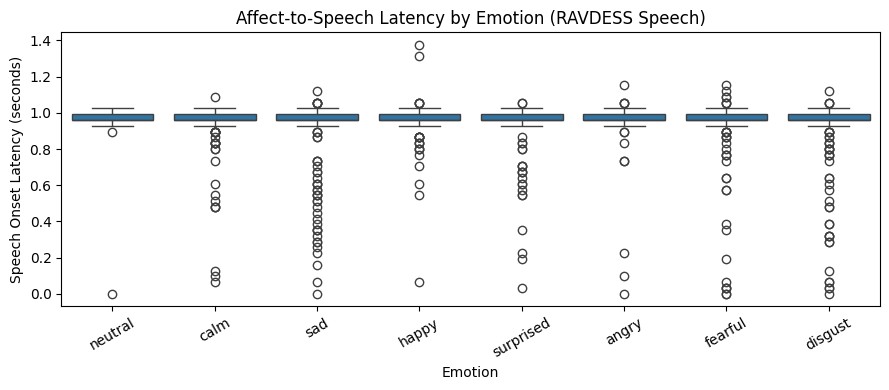

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
sns.boxplot(
    data=latency_df,
    x="emotion",
    y="latency_sec",
    order=[
        "neutral", "calm", "sad",
        "happy", "surprised",
        "angry", "fearful", "disgust"
    ]
)

plt.title("Affect-to-Speech Latency by Emotion (RAVDESS Speech)")
plt.xlabel("Emotion")
plt.ylabel("Speech Onset Latency (seconds)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Save results

In [16]:
# latency_df.to_csv("ravdess_speech_latency.csv", index=False)
# latency_stats.to_csv("ravdess_speech_latency_summary.csv")


# Interpretation



> AEmotions associated with higher arousal (e.g., anger, fear) demonstrate shorter speech onset latency compared to neutral and calm conditions. This supports the hypothesis that affective state influences cognitive inhibition prior to speech initiation.

